## 0

Объявление данных для работы, небольшие изменения по сравнению с тем, как это сделано в методичке

In [1]:
id <- 1:3
country <- c("Flatland", "Wonderland", "Sphereland")
craziness <- c(20, 15, 18)
region_type <- c("A", "B", "A")
author <- c("Abbot", "Carroll", "Burger")
size <- c(10, 100, 30)

df <- data.frame(id, country, craziness, region_type, author, size)

In [2]:
df

id,country,craziness,region_type,author,size
1,Flatland,20,A,Abbot,10
2,Wonderland,15,B,Carroll,100
3,Sphereland,18,A,Burger,30


In [3]:
sapply(df, class)

id     country   craziness region_type      author        size 
  "integer"    "factor"   "numeric"    "factor"    "factor"   "numeric"

## 1

Описывает, сколько переменных указанных типов в dataframe'е

In [4]:
first <- function(df, describeVector=c("numeric", "factor", "character")) {
    #classes <- sapply(df, class)
    classes <- c()
    for (i in 1:length(df[1,])) {
        classes <- c(classes, class(df[,i]))
    }
    # ;)
    classes <- table(classes)
    
    naToZero <- function(x) if (is.na(x)) 0 else x
    for (name in describeVector) {
        classes[name] <- naToZero(classes[name])
    }
    
    return (c(classes[describeVector]))
}

In [5]:
first(df)

numeric    factor character 
        2         3         0

## 2

А эта выбирает только столбцы указанного типа

In [6]:
second <- function(df, choose='numeric') {
    result <- data.frame(temp = rep(c(0), length(df[1,])))
    for (i in 1:length(df[1,])) {
        if (class(df[,i]) == choose) {
            result[colnames(df[i])] <- df[i]
        }
    }
    
    result <- result[-1]
    
    return (result)
}

In [7]:
second(df)

craziness,size
20,10
15,100
18,30
20,10
15,100
18,30


## 4

In [8]:
four <- function(vector) {
    if (class(vector) == "numeric") {
        return (median(vector))
    }
    else {
        print("Vector is not numeric, cannot compute the median")
        return (NA)
    }
}

In [9]:
four(c(1, 2, 3, 4, 5, 6))

[1] 3.5

In [10]:
four("Hello")

[1] "Vector is not numeric, cannot compute the median"


[1] NA

# Анализ временных рядов

In [41]:
if ("quantmod" %in% rownames(installed.packages()) == FALSE) {
    install.packages("quantmod") 
}
library(quantmod)

In [42]:
if ("stringr" %in% rownames(installed.packages()) == FALSE) {
    install.packages("stringr") 
}
library(stringr)

In [43]:
downloadable_stocks <- c("ATVI", "^IXIC")

In [44]:
quantmod::getSymbols(Symbols = downloadable_stocks, src = "yahoo", from = as.Date.character("1900-01-01"))

[1] "ATVI"  "^IXIC"

In [45]:
df <- data.frame(get(downloadable_stocks[1]))

In [46]:
downloadable_stocks <- stringr::str_remove(downloadable_stocks, "[:punct:\\^]")

In [47]:
rm(list = downloadable_stocks)

In [48]:
head(df)

,ATVI.Open,ATVI.High,ATVI.Low,ATVI.Close,ATVI.Volume,ATVI.Adjusted
1993-10-25,1.250000,1.250000,0.937500,0.937500,18000,0.840151
1993-10-26,1.229167,1.229167,0.854167,0.864583,189600,0.774806
1993-10-27,0.864583,0.864583,0.864583,0.864583,0,0.774806
1993-10-28,0.708333,0.833333,0.583333,0.822917,30000,0.737466
1993-10-29,0.875000,0.875000,0.833333,0.833333,172800,0.746801
1993-11-01,0.833333,0.875000,0.833333,0.875000,76800,0.784141


## 2

Реализация пропорций:

In [49]:
proportion <- function(x, dt, func) {
    stopifnot(is.vector(x) && class(x) == "numeric")
    stopifnot(is.numeric(dt) & dt %% 1 == 0 & dt > 0)
    stopifnot(2*dt < length(x))
    stopifnot(is.function(func))
    
    min_elem <- min(x)
    x <- sapply(x, function(x) x + min_elem + 1)
    
    y <- rep(c(0), length(x) - 2*dt)
    for (i in (1 + dt):(length(x) - dt)) {
        y[i - dt] <- func(x[i - dt], x[i], x[i + dt])
    }
    
    return (y)
}

In [50]:
arifmProportion <- function(x, dt=1) proportion(x, dt, function(prev, current, nex) log((prev + nex) / (2*current)))

In [51]:
arifmProportion(c(1, 2, 1, 4, 3, 1, 7), 2)

[1]  0.2876821 -0.5389965  0.1823216

In [52]:
geomProportion <- function(x, dt=1) proportion(x, dt, function(prev, current, nex) log(prev * nex /  current^2))

In [53]:
geomProportion(c(1, 2, 1, 4, 3, 1, 7), 2)

[1]  0.51082562 -1.09861229  0.07696104

In [54]:
garmProportion <- function(x, dt=1) proportion(x, dt, function(prev, current, nex) log(2 * prev * nex / (current * (prev + nex))))

In [55]:
garmProportion(c(1, 2, 1, 4, 3, 1, 7), 2)

[1]  0.2231436 -0.5596158 -0.1053605

**Сама функция *out_of_trend***

In [56]:
out_of_trend <- function(x, dt=1, method="Arifm") {
    stopifnot(method == "Arifm" || method == "Geom" || method == "Garm")
    
    return (switch(method,
                  "Arifm"=arifmProportion(x, dt),
                  "Geom"=geomProportion(x, dt),
                  "Garm"=garmProportion(x, dt),
                  arifmProportion(x, dt)))
}

In [57]:
out_of_trend(c(1, 2, 1, 4, 3, 1, 7), 2) == arifmProportion(c(1, 2, 1, 4, 3, 1, 7), 2)

[1] TRUE TRUE TRUE

In [58]:
out_of_trend(c(1, 2, 1, 4, 3, 1, 7), 2, "Geom") == geomProportion(c(1, 2, 1, 4, 3, 1, 7), 2)

[1] TRUE TRUE TRUE

In [59]:
out_of_trend(c(1, 2, 1, 4, 3, 1, 7), 2, "Garm") == garmProportion(c(1, 2, 1, 4, 3, 1, 7), 2)

[1] TRUE TRUE TRUE

## 3

In [60]:
t = seq(0, 10, 0.1)

In [61]:
x = 2*t + 3 + sin(2*t)

In [62]:
mean(x)

[1] 13.03372

In [63]:
xn <- out_of_trend(x, method="Arifm")
mean(xn)

[1] -6.821495e-05

In [64]:
xn <- out_of_trend(x, method="Geom")
mean(xn)

[1] -0.0004506113

In [65]:
xn <- out_of_trend(x, method="Garm")
mean(xn)

[1] -0.0003823964

Ну вот мне кажется, что среднее геометрическое и гармоническое около нуля из-за этой фигни:

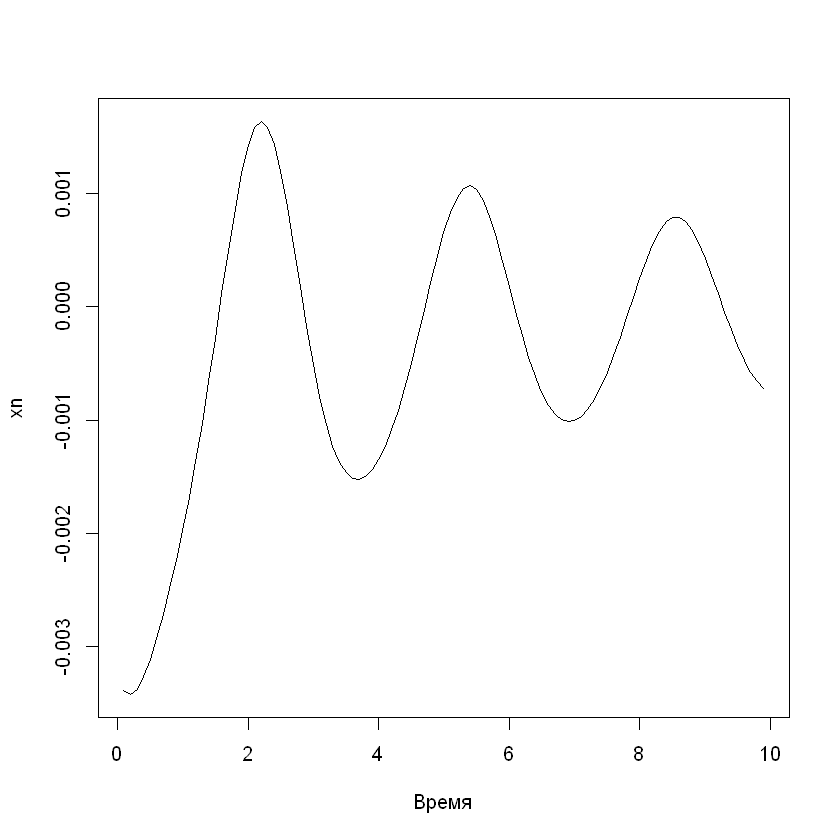

In [66]:
plot(t[2:(length(t) - 1)], xn, type="l", xlab="Время", ylab="xn")

## 4

In [67]:
AlterJohns_Tau <- function(y, tau) {
    stopifnot(is.vector(y) & is.numeric(y))
    n <- length(y)
    stopifnot(is.numeric(tau) & tau %% 1 == 0 & n > tau)
    
    summa <- 0
    for (i in 1:(n - tau)) {
        summa <- summa + abs(y[i + tau] - y[i])
    }
    
    return (1 / (n - tau) * summa)
}

AlterJohns <- function(y) {
    return (sapply(1:(length(y) - 1), function(i) (AlterJohns_Tau(y, i))))
}

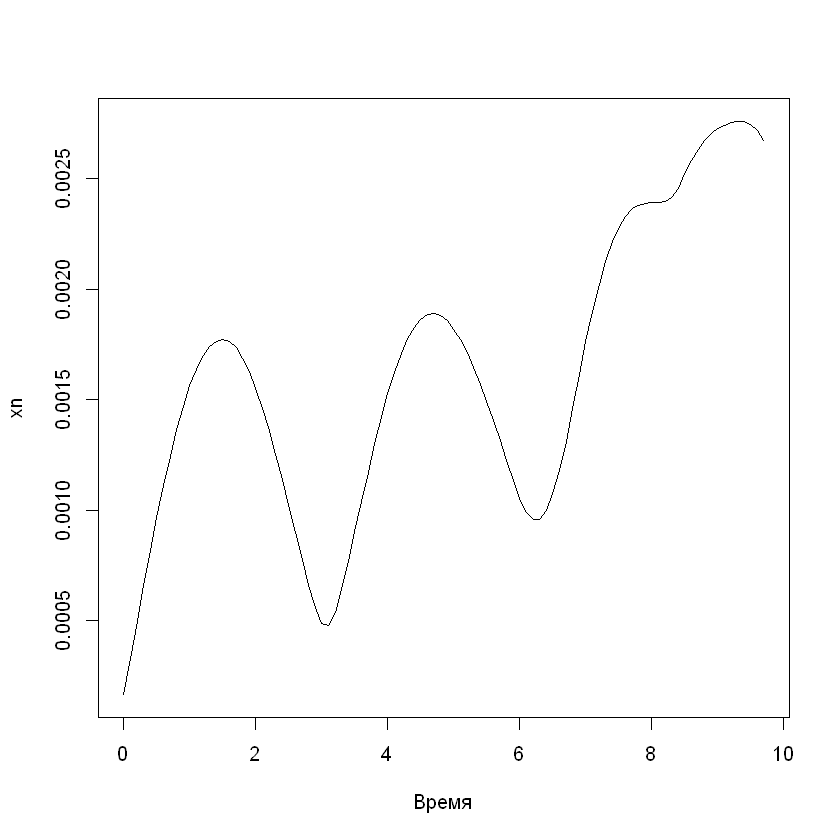

In [68]:
plot(t[1:(length(xn) - 1)], AlterJohns(xn), type="l", xlab="Время", ylab="xn")

## 6

In [69]:
out_of <- out_of_trend(df[[1]], method="Geom")

In [70]:
result <- AlterJohns(out_of)

In [71]:
head(result)

[1] 0.03859402 0.03154444 0.03186798 0.03190609 0.03234020 0.03151622

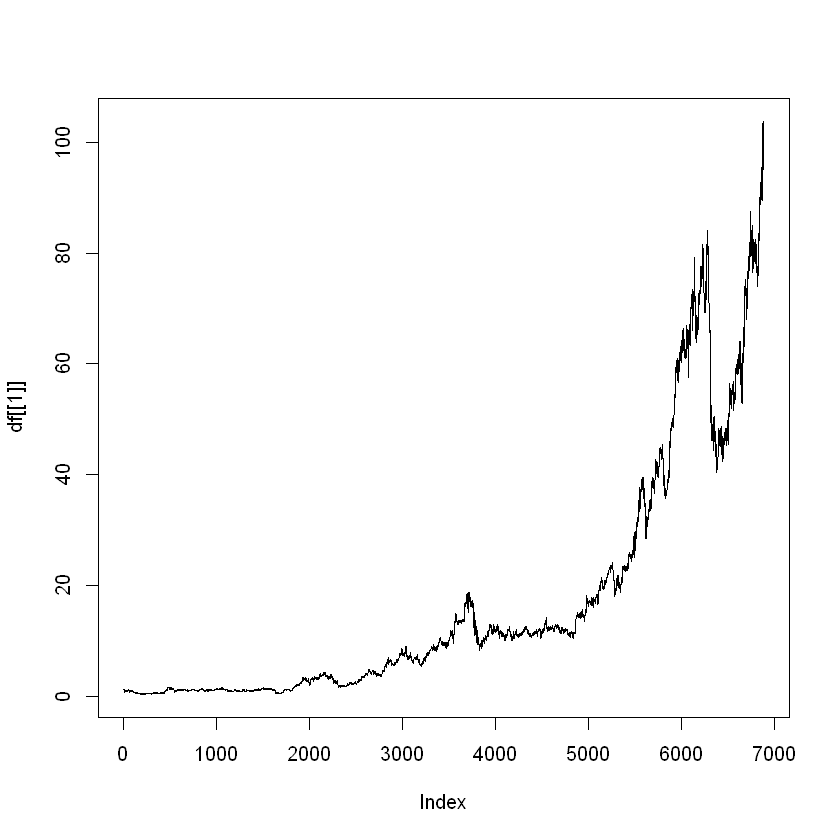

In [72]:
plot(df[[1]], type="l")

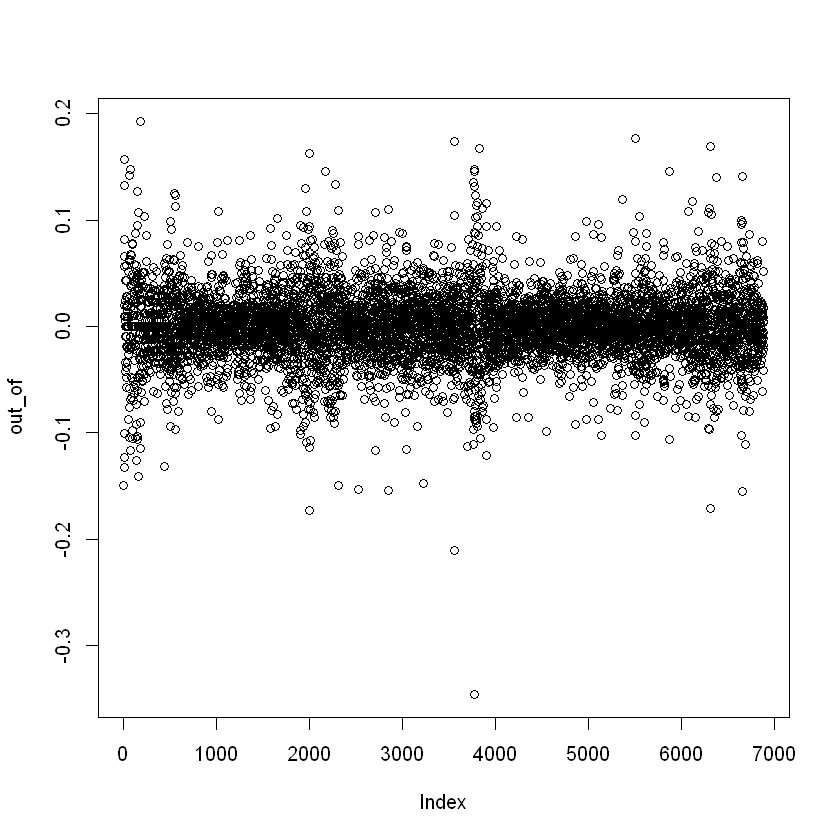

In [73]:
plot(out_of)